(dry_lesII)=
# II: dry boundary layer -- inversion height

Add a cells at the end to plot inversion height vs. time

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

the_file = Path.home() / "Dropbox/phil_files/a500/data" / "case_60_10.nc"
if not the_file.exists():
    raise ValueError(f"{the_file} not found")

## Find the netcdf file an dump its contents

In [2]:
the_file

PosixPath('/Users/phil/Dropbox/phil_files/a500/data/case_60_10.nc')

In [3]:
!ncdump -h /Users/phil/Dropbox/phil_files/a500/data/case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100LL ;
		:gamma_K_km = 10LL ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;


Netcdf file layout:  10 groups corresponding to 10 different ensemble members.  Small slice of larger domain of LES run with surface heat flux of 60 W/m^2 and stable layer with dT/dz = 10 K/km.  Snapshots every 10 minutes for 8 hours.

## Open the first ensemble member c1

Look at the last 5 values of z, pressure

From the ncdump we know that there are global variables and attributes as
well as the 10 ensemble members.  So get two xarray dataset pointers:

- ds1 for the first ensemble member
- the_ds for the global variables

In [4]:
ds1 = xr.open_dataset(the_file,group="c1")
the_ds = xr.open_dataset(the_file)

In [5]:
the_ds['z'][-5:]

<xarray.DataArray 'z' (z: 5)>
array([1025., 1030., 1035., 1040., 1045.], dtype=float32)
Coordinates:
  * z        (z) float32 1.025e+03 1.03e+03 1.035e+03 1.04e+03 1.045e+03
Attributes:
    units:    meters

In [6]:
ds1

<xarray.Dataset>
Dimensions:  (time: 48, z: 130, y: 20, x: 25)
Dimensions without coordinates: time, z, y, x
Data variables:
    TABS     (time, z, y, x) float32 ...
    W        (time, z, y, x) float32 ...
    U        (time, z, y, x) float32 ...
    V        (time, z, y, x) float32 ...

### Get variable vectors and dimension sizes

In [7]:
temp = ds1['TABS']
wvel= ds1['W']
times = the_ds['time']
z=the_ds['z']
y = the_ds['y']
x = the_ds['x']
press=the_ds['press']
ntimes,nz,ny,nx = ds1.sizes.values()
print(f"{(ntimes,nz,ny,nx)=}")

(ntimes,nz,ny,nx)=(48, 130, 20, 25)


In [8]:
y

<xarray.DataArray 'y' (y: 20)>
array([2000., 2025., 2050., 2075., 2100., 2125., 2150., 2175., 2200., 2225.,
       2250., 2275., 2300., 2325., 2350., 2375., 2400., 2425., 2450., 2475.],
      dtype=float32)
Coordinates:
  * y        (y) float32 2e+03 2.025e+03 2.05e+03 ... 2.45e+03 2.475e+03
Attributes:
    units:    meters

## check height and pressure

In [9]:
(z[-5:].data,press[-5:].data)

(array([1025., 1030., 1035., 1040., 1045.], dtype=float32),
 array([88980.79 , 88930.06 , 88879.445, 88828.77 , 88778.21 ],
       dtype=float32))

## Function to convert to $\theta$

In [10]:
def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    theta=temp*(p0/press)**(Rd/cpd)
    
    return theta
    

## Get the horizontal average

In [11]:
temp_mean=temp.mean(dim=["x","y"])

In [12]:
temp_mean[0,-5:]

<xarray.DataArray 'TABS' (z: 5)>
array([299.92114, 299.9195 , 299.918  , 299.91644, 299.9148 ],
      dtype=float32)
Dimensions without coordinates: z

In [13]:
## Plot the timestep theta,height profiles for c1

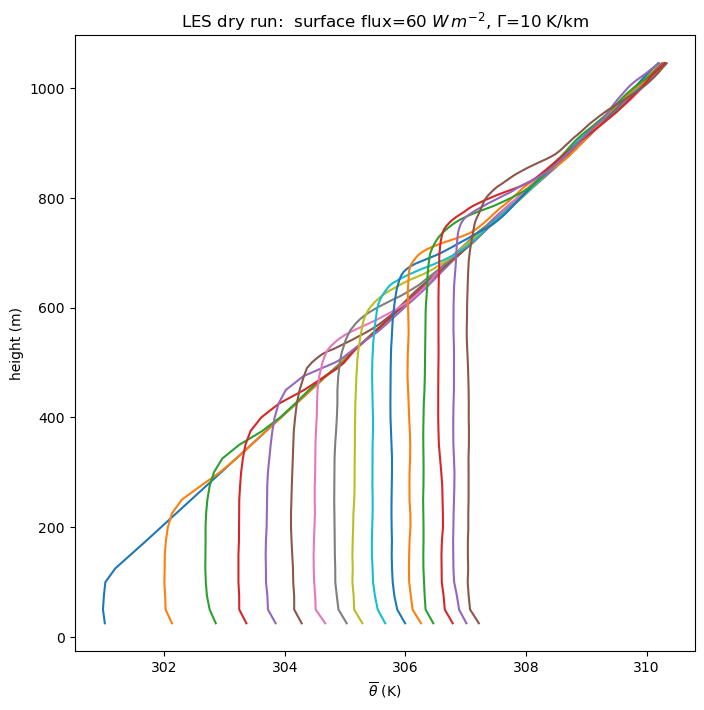

In [14]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ntimes, nheights = temp_mean.shape
for i in np.arange(0,ntimes,3):
    theta = make_theta(temp_mean[i,:],press)
    ax.plot(theta,z)
ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km');

    

## Assignment -- targeting Tuesday

- Write functions that find the ensemble mean $\langle \zeta \rangle$ and the perturbation about that mean $\zeta^\prime$ an arbitrary variable $\zeta$
- Use those functions to calculate the horizontally averaged vertical entropy flux $\overline{w^\prime\,\theta^\prime}$ as a function of height and make a plot similar to the figure above

## Assignment solution

### Collect all 10 ensemble members into a dicionary

In [15]:
ensemble_names = [f"c{i}" for i in np.arange(1,11)]

In [16]:
ensemble_names

['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10']

In [17]:
ds_dict = {}
for count, name in enumerate(ensemble_names):
    ds = xr.open_dataset(the_file,group=name)
    ds_dict[count] = ds

In [18]:
import numpy.typing as npt
def make_array(var_dict: dict, 
               varname: str,
               times: npt.ArrayLike,
               x: npt.ArrayLike, 
               y: npt.ArrayLike,
               z: npt.ArrayLike, 
               press:npt.ArrayLike):
    # given a dictionary of ensemble members, 
    # create a new data array containing variable varname
    #
    n_ensembles = len(var_dict)
    #
    # get shapes and attrs from first ensemble member
    #
    attrs = var_dict[0][varname].attrs
    print(f"{attrs=}")
    ntimes, nz, ny, nx = var_dict[0][varname].shape
    var_array = np.empty((n_ensembles,ntimes,nz,ny,nx))
    for ensemble in range(n_ensembles):
        print(f"working on {ensemble=}")
        var_array[ensemble,...] = var_dict[ensemble][varname][...]
    ensemble_coord = list(range(n_ensembles))
    coords = {'ensemble' : ensemble_coord,'time':times, 'z': z, 'y' : y, 'x' : x}
    dims = ('ensemble','time','z','y','x')
    the_array = xr.DataArray(var_array,coords=coords,dims=dims,attrs=attrs,name=varname)
    return the_array

### Function to turn TABS and press membeers from a  dictionary into a 5-d theta array

#### First try this without broadcasting

Since pressure is a 1-d vec of length 130 you can't multiply that shape
with a 5 dimensional ensemble and have the make_theta function work.
So loop over all dimensions except z so that shapes will match

This takes a considerable amount of time in python

In [19]:
def make_theta_array(var_dict: dict, 
               times: npt.ArrayLike,
               x: npt.ArrayLike, 
               y: npt.ArrayLike,
               z: npt.ArrayLike, 
               press:npt.ArrayLike):
    #
    # given a dictionary of ensemble members, 
    # create a new data array converting TABS and press to 
    # potential temperature
    #
    n_ensembles = len(var_dict)
    #
    # get shapes and attrs from TABS for first ensemble member
    #
    ntimes, nz, ny, nx = var_dict[0]['TABS'].shape
    attrs = var_dict[0]['TABS'].attrs
    print(f"{attrs=}")
    theta_array = np.empty((n_ensembles,ntimes,nz,ny,nx))
    for ensemble in range(n_ensembles):
        print(f"working on {ensemble=}")
        for timestep in range(ntimes):
            the_tabs = var_dict[ensemble]['TABS'][timestep,...]
            for xindex in range(len(x)):
                for yindex in range(len(y)):
                   theta_array[ensemble,timestep,:,yindex,xindex]= \
                        make_theta(the_tabs[:,yindex,xindex],press)
    ensemble_coord = list(range(n_ensembles))
    coords = {'ensemble' : ensemble_coord,'time':times, 'z': z, 'y' : y, 'x' : x}
    dims = ('ensemble','time','z','y','x')
    the_array = xr.DataArray(theta_array,coords=coords,dims=dims,attrs=attrs,name='theta')
    return the_array

####  Now do this with broadcasting

We need to promote press into a 5-d array that will broadcast with
the ensemble array which has shape [10, 48,130, 20, 25]  That means
that press needs to have shape [1,1,130,1,1].  We can do htat with
[np.expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html)  The rules
for broadcasting are covered here:  [numpy.broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)

In [20]:
def make_theta_broadcast(var_dict: dict, 
               times: npt.ArrayLike,
               x: npt.ArrayLike, 
               y: npt.ArrayLike,
               z: npt.ArrayLike, 
               press:npt.ArrayLike):
    #
    # given a dictionary of ensemble members, 
    # create a new data array converting TABS and press to 
    # potential temperature
    #
    n_ensembles = len(var_dict)
    #
    # get shapes and attrs from TABS for first ensemble member
    #
    ntimes, nz, ny, nx = var_dict[0]['TABS'].shape
    attrs = var_dict[0]['TABS'].attrs
    print(f"{attrs=}")
    #
    # for broadcasting give press the shape [1,1,130,1,1]
    #
    press_array = np.expand_dims(press,axis=(0,1,-1,-2))
    tabs_array = np.empty((n_ensembles,ntimes,nz,ny,nx))
    for ensemble in range(n_ensembles):
        print(f"working on {ensemble=}")
        tabs_array[ensemble,...] = var_dict[ensemble]['TABS'][...]
    theta_array = make_theta(tabs_array,press_array)
    ensemble_coord = list(range(n_ensembles))
    coords = {'ensemble' : ensemble_coord,'time':times, 'z': z, 'y' : y, 'x' : x}
    dims = ('ensemble','time','z','y','x')
    the_array = xr.DataArray(theta_array,coords=coords,dims=dims,attrs=attrs,name='theta')
    return the_array

Here's how you use expand_dims to add axis on either size of the z axis

In [21]:
out=np.expand_dims(press,axis=(0,1,-1,-2))
out.shape

(1, 1, 130, 1, 1)

### create the theta array

We'll write theta to disk as zarr file.  zarr is a successor to netcdf optimized for use in the cloud.  See [https://zarr.dev/](https://zarr.dev/)

In [22]:
import zarr
zarrfile = 'theta.zarr'
write = True
if write:
    theta  = make_theta_broadcast(ds_dict,times,x,y,z,press)
    theta.to_zarr(zarrfile,mode='w')
else:
    theta_ds = xr.open_zarr(zarrfile)
    theta = theta_ds['theta']

attrs={'units': 'K'}
working on ensemble=0
working on ensemble=1
working on ensemble=2
working on ensemble=3
working on ensemble=4
working on ensemble=5
working on ensemble=6
working on ensemble=7
working on ensemble=8
working on ensemble=9


In [23]:
theta

<xarray.DataArray 'theta' (ensemble: 10, time: 48, z: 130, y: 20, x: 25)>
array([[[[[301.06942833, 301.20943434, 300.91189103, ...,
           301.16997366, 300.93873773, 300.88886211],
          [300.89692529, 300.93021642, 301.0800876 , ...,
           300.91778569, 301.00461752, 301.05876906],
          [300.97007415, 301.17027908, 301.08644041, ...,
           300.92884202, 300.98583399, 301.17415796],
          ...,
          [300.92340548, 301.03143368, 301.0466743 , ...,
           300.95581089, 300.91027228, 300.92957503],
          [301.16725539, 300.93275143, 300.97123476, ...,
           301.05079751, 300.93855447, 300.92975829],
          [301.13848452, 301.0387333 , 300.9714791 , ...,
           301.12409909, 300.96497358, 301.03961902]],

         [[300.98024343, 300.95887701, 300.92928804, ...,
           301.0262775 , 300.89129312, 300.87928024],
          [300.98271936, 301.01701567, 300.98498133, ...,
           300.91223159, 300.95933552, 300.99800292],
          [301.08331574, 301.1687814 , 301.04446494, ...,
           300.97419114, 300.93261986, 301.10535464],
...
          [310.03307339, 310.0935274 , 310.14855159, ...,
           309.97779664, 309.9479011 , 310.04661635],
          [309.9944649 , 310.05378244, 310.07199756, ...,
           309.97886997, 310.00384079, 310.02031964],
          [309.95639308, 310.022782  , 310.0878766 , ...,
           310.05592911, 310.0616746 , 310.0139112 ]],

         [[310.21565808, 310.21752094, 310.25866162, ...,
           310.21641586, 310.19115681, 310.14761652],
          [310.22232016, 310.21973111, 310.26646035, ...,
           310.11680048, 310.08885766, 310.09485669],
          [310.19137782, 310.23706513, 310.21606854, ...,
           310.14133333, 310.11784242, 310.07089216],
          ...,
          [310.08623703, 310.17650656, 310.16766589, ...,
           310.05545257, 309.98829507, 310.10650742],
          [310.05646293, 310.11860019, 310.16394018, ...,
           310.04566469, 310.08279549, 310.10530762],
          [310.02773076, 310.06962921, 310.08039588, ...,
           310.16103539, 310.05460008, 310.09157301]]]]])
Coordinates:
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * time      (time) timedelta64[ns] 02:49:00.416564940 ... 02:49:19.999694826
  * z         (z) float32 25.0 50.0 75.0 100.0 ... 1.035e+03 1.04e+03 1.045e+03
  * y         (y) float32 2e+03 2.025e+03 2.05e+03 ... 2.45e+03 2.475e+03
  * x         (x) float32 2e+03 2.025e+03 2.05e+03 ... 2.575e+03 2.6e+03
Attributes:
    units:    K

In [24]:
wvel = make_array(ds_dict,'W',times,x,y,z,press)

attrs={'units': 'm/s'}
working on ensemble=0
working on ensemble=1
working on ensemble=2
working on ensemble=3
working on ensemble=4
working on ensemble=5
working on ensemble=6
working on ensemble=7
working on ensemble=8
working on ensemble=9


In [25]:
w_mean = wvel.mean(dim=['ensemble'])
w_perturb = wvel - w_mean
theta_mean = theta.mean(dim=['ensemble'])
theta_perturb = theta - theta_mean
theta_flux = theta_perturb*w_perturb
ensemble_mean = theta_flux.mean(dim=['ensemble'])
ensemble_horizavg = ensemble_mean.mean(dim=['x','y'])
ensemble_horizavg.shape

(48, 130)

In [26]:
the_ds

<xarray.Dataset>
Dimensions:  (time: 48, x: 25, y: 20, z: 130)
Coordinates:
  * time     (time) timedelta64[ns] 02:49:00.416564940 ... 02:49:19.999694826
  * x        (x) float32 2e+03 2.025e+03 2.05e+03 ... 2.55e+03 2.575e+03 2.6e+03
  * y        (y) float32 2e+03 2.025e+03 2.05e+03 ... 2.45e+03 2.475e+03
  * z        (z) float32 25.0 50.0 75.0 100.0 ... 1.035e+03 1.04e+03 1.045e+03
Data variables:
    press    (z) float32 9.972e+04 9.943e+04 9.915e+04 ... 8.883e+04 8.878e+04
Attributes:
    heat_flux_W_m2:  100
    gamma_K_km:      10

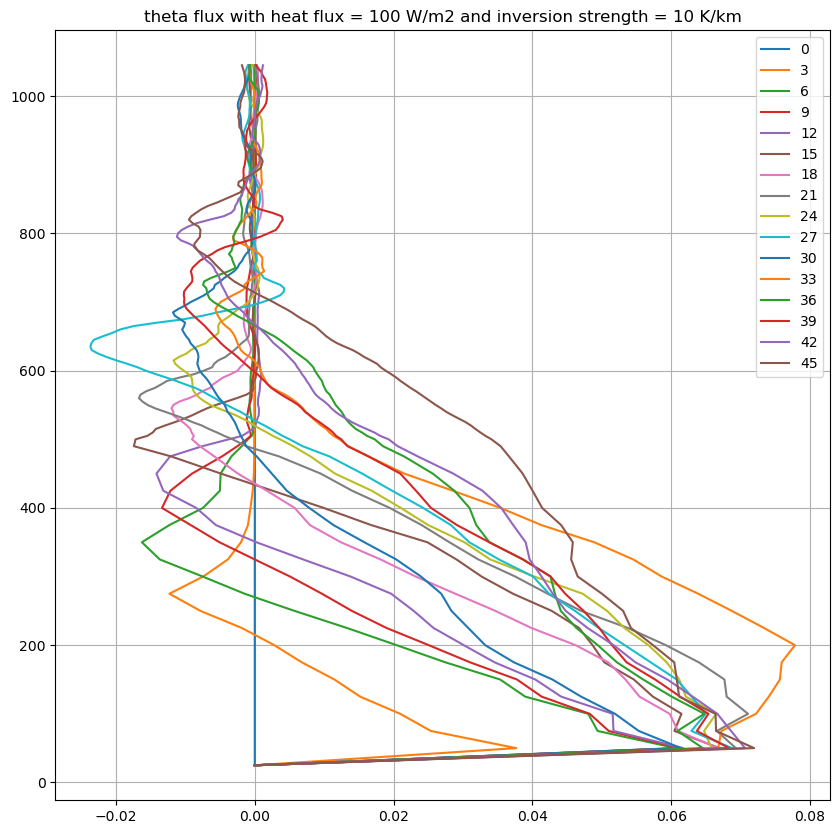

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for timestep in np.arange(0,ntimes,3):
    ax.plot(ensemble_horizavg[timestep,:],z,label=timestep)
ax.legend(loc='best')
heat_flux = the_ds.attrs['heat_flux_W_m2']
gamma = the_ds.attrs['gamma_K_km']
ax.grid(True)
ax.set_title(f"theta flux with heat flux = {heat_flux} W/m2 and inversion strength = {gamma} K/km");

In [28]:
theta

<xarray.DataArray 'theta' (ensemble: 10, time: 48, z: 130, y: 20, x: 25)>
array([[[[[301.06942833, 301.20943434, 300.91189103, ...,
           301.16997366, 300.93873773, 300.88886211],
          [300.89692529, 300.93021642, 301.0800876 , ...,
           300.91778569, 301.00461752, 301.05876906],
          [300.97007415, 301.17027908, 301.08644041, ...,
           300.92884202, 300.98583399, 301.17415796],
          ...,
          [300.92340548, 301.03143368, 301.0466743 , ...,
           300.95581089, 300.91027228, 300.92957503],
          [301.16725539, 300.93275143, 300.97123476, ...,
           301.05079751, 300.93855447, 300.92975829],
          [301.13848452, 301.0387333 , 300.9714791 , ...,
           301.12409909, 300.96497358, 301.03961902]],

         [[300.98024343, 300.95887701, 300.92928804, ...,
           301.0262775 , 300.89129312, 300.87928024],
          [300.98271936, 301.01701567, 300.98498133, ...,
           300.91223159, 300.95933552, 300.99800292],
          [301.08331574, 301.1687814 , 301.04446494, ...,
           300.97419114, 300.93261986, 301.10535464],
...
          [310.03307339, 310.0935274 , 310.14855159, ...,
           309.97779664, 309.9479011 , 310.04661635],
          [309.9944649 , 310.05378244, 310.07199756, ...,
           309.97886997, 310.00384079, 310.02031964],
          [309.95639308, 310.022782  , 310.0878766 , ...,
           310.05592911, 310.0616746 , 310.0139112 ]],

         [[310.21565808, 310.21752094, 310.25866162, ...,
           310.21641586, 310.19115681, 310.14761652],
          [310.22232016, 310.21973111, 310.26646035, ...,
           310.11680048, 310.08885766, 310.09485669],
          [310.19137782, 310.23706513, 310.21606854, ...,
           310.14133333, 310.11784242, 310.07089216],
          ...,
          [310.08623703, 310.17650656, 310.16766589, ...,
           310.05545257, 309.98829507, 310.10650742],
          [310.05646293, 310.11860019, 310.16394018, ...,
           310.04566469, 310.08279549, 310.10530762],
          [310.02773076, 310.06962921, 310.08039588, ...,
           310.16103539, 310.05460008, 310.09157301]]]]])
Coordinates:
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * time      (time) timedelta64[ns] 02:49:00.416564940 ... 02:49:19.999694826
  * z         (z) float32 25.0 50.0 75.0 100.0 ... 1.035e+03 1.04e+03 1.045e+03
  * y         (y) float32 2e+03 2.025e+03 2.05e+03 ... 2.45e+03 2.475e+03
  * x         (x) float32 2e+03 2.025e+03 2.05e+03 ... 2.575e+03 2.6e+03
Attributes:
    units:    K

In [29]:
theta_perturb

<xarray.DataArray 'theta' (ensemble: 10, time: 48, z: 130, y: 20, x: 25)>
array([[[[[-4.45612502e-02, -4.51262832e-02, -4.47567211e-02, ...,
           -4.48055888e-02, -4.47047991e-02, -4.49796800e-02],
          [-4.44329725e-02, -4.47903176e-02, -4.45673587e-02, ...,
           -4.46223349e-02, -4.45826298e-02, -4.50682528e-02],
          [-4.46314976e-02, -4.47689380e-02, -4.46162264e-02, ...,
           -4.47292330e-02, -4.47200703e-02, -4.45001656e-02],
          ...,
          [-4.44574063e-02, -4.44574063e-02, -4.46131722e-02, ...,
           -4.44971113e-02, -4.46773110e-02, -4.45856841e-02],
          [-4.48483481e-02, -4.45765214e-02, -4.43077489e-02, ...,
           -4.43932674e-02, -4.45795756e-02, -4.45856841e-02],
          [-4.45459791e-02, -4.47658838e-02, -4.42924778e-02, ...,
           -4.49552462e-02, -4.43932674e-02, -4.45979010e-02]],

         [[-4.46616139e-02, -4.46585572e-02, -4.47563720e-02, ...,
           -4.49306045e-02, -4.47135780e-02, -4.45271186e-02],
          [-4.45210052e-02, -4.44140202e-02, -4.48755837e-02, ...,
           -4.46555005e-02, -4.42520145e-02, -4.45790827e-02],
          [-4.44904380e-02, -4.48113928e-02, -4.45546290e-02, ...,
           -4.46616139e-02, -4.46860676e-02, -4.45637991e-02],
...
          [-2.25848607e-01, -1.59027195e-01, -1.19490587e-01, ...,
           -3.33737706e-01, -3.68883111e-01, -2.70578261e-01],
          [-2.40906864e-01, -1.82337503e-01, -1.67471815e-01, ...,
           -3.33775589e-01, -2.98058791e-01, -2.57196300e-01],
          [-2.70480398e-01, -2.20936521e-01, -1.46181901e-01, ...,
           -2.42198023e-01, -2.41279374e-01, -2.73504677e-01]],

         [[-1.34880162e-01, -1.38242773e-01, -8.08384275e-02, ...,
           -8.75731214e-02, -1.13283675e-01, -1.52356266e-01],
          [-1.38915295e-01, -1.38722695e-01, -9.25365244e-02, ...,
           -1.87886275e-01, -2.08188236e-01, -2.05908606e-01],
          [-1.61140100e-01, -1.46672980e-01, -1.44020780e-01, ...,
           -1.54556961e-01, -1.84659432e-01, -2.37138263e-01],
          ...,
          [-2.17063634e-01, -1.18464938e-01, -1.52971955e-01, ...,
           -2.97194808e-01, -3.79368808e-01, -2.76927579e-01],
          [-2.26646285e-01, -1.64600590e-01, -1.35164326e-01, ...,
           -3.22254942e-01, -2.83239184e-01, -2.35256464e-01],
          [-2.54254425e-01, -2.45606359e-01, -1.96531185e-01, ...,
           -1.93193833e-01, -2.92256664e-01, -2.44835958e-01]]]]])
Coordinates:
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * time      (time) timedelta64[ns] 02:49:00.416564940 ... 02:49:19.999694826
  * z         (z) float32 25.0 50.0 75.0 100.0 ... 1.035e+03 1.04e+03 1.045e+03
  * y         (y) float32 2e+03 2.025e+03 2.05e+03 ... 2.45e+03 2.475e+03
  * x         (x) float32 2e+03 2.025e+03 2.05e+03 ... 2.575e+03 2.6e+03

## Tracking the inversion height

Stull p. 456 equation 11.2.2f says:

$$
z_i^2-z_{i_0}^2=\frac{2}{\gamma}\left[\overline{w^{\prime} \theta_s^{\prime}}-\overline{w^{\prime} \theta_{z_i}^{\prime}}\right] \cdot\left(t-t_o\right)
$$
that is, the height of the inversion increases as the square root of time.  Does that hold for our dry LES run?

Go through our ensemble horizontal average and find the first height where the flux becomes negative.  Plot these heights agains the square root of time.  Do we get a straight line?

In [30]:
inversion_base = list()
for time_step in range(ntimes):
    #
    # where returns a tuple, find the smallest height
    #
    hit = np.where(ensemble_horizavg[time_step,:] < 0)[0][0]
    inversion_base.append(z[hit])
    

### Timesteps are stored in a weird format

Convert the timesteps from seconds to minutes by normalizing by 1 second, and multiplying by 60.  (Possible dataset mislabelling, this gives 1174 seconds for the time series, which is about 20 minutes.

In [31]:
timesteps = np.diff(the_ds.coords['time'])/np.timedelta64(1, 's')*60
time_values = np.cumsum(timesteps)
time_vector = np.concatenate((np.array([0.]),time_values))
time_vector

array([   0.        ,   24.9938964 ,   49.98779316,   74.98168956,
        100.03051764,  125.02441404,  150.0183108 ,  175.0122072 ,
        200.0061036 ,  225.        ,  249.9938964 ,  274.98779316,
        299.98168956,  325.03051764,  350.02441404,  375.0183108 ,
        400.0122072 ,  425.0061036 ,  450.        ,  474.9938964 ,
        499.98779316,  524.98168956,  550.03051764,  575.02441404,
        600.0183108 ,  625.0122072 ,  650.0061036 ,  675.        ,
        699.9938964 ,  724.98779316,  749.98168956,  775.03051764,
        800.02441404,  825.0183108 ,  850.0122072 ,  875.0061036 ,
        900.        ,  924.9938964 ,  949.9877931 ,  974.98168956,
       1000.03051764, 1025.02441404, 1050.0183108 , 1075.0122072 ,
       1100.0061036 , 1125.        , 1149.9938964 , 1174.98779316])

In [32]:
len(time_vector),len(inversion_base)

(48, 48)

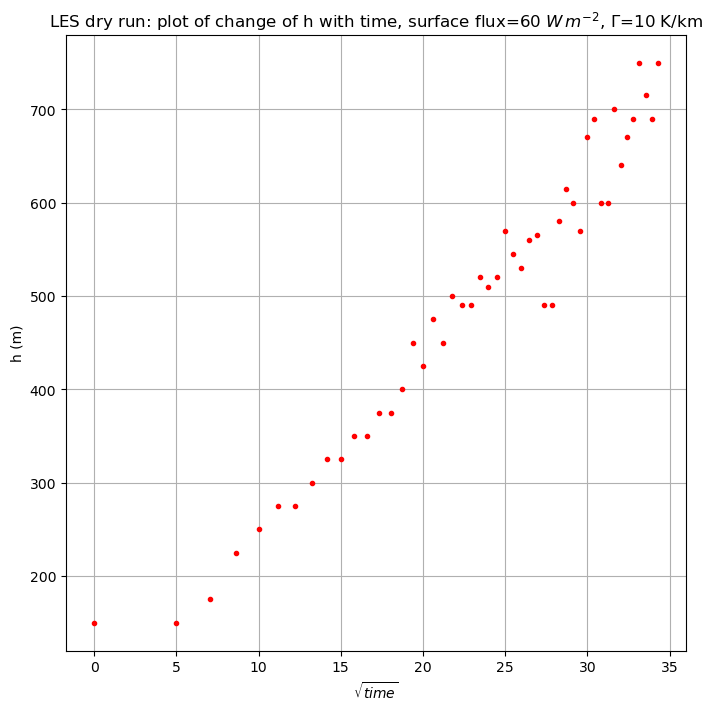

In [33]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
# time is arranged linearly, so I can just use time index and take square root of that
ax.plot(np.sqrt(time_vector),inversion_base, 'r.')
ax.set(xlabel=r"$\sqrt{time}$",ylabel='h (m)',
       title='LES dry run: plot of change of h with time, surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')
ax.grid(True)